# VGG-16 Model

In [1]:
import keras
import os, shutil
from keras import models, layers, losses, optimizers, metrics
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
%matplotlib inline

train_dir = 'E:\\Datasets\\CACD_cropped\\train'
test_dir = 'E:\\Datasets\\CACD_cropped\\test'

train_datagen = ImageDataGenerator(rescale=1./255, 
#                                    rotation_range=15, 
#                                    width_shift_range=0.1, 
#                                    height_shift_range=0.1, 
#                                    shear_range=0.1,
#                                    zoom_range=0.15, 
#                                    horizontal_flip=True
                                  )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(128, 128), 
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(128, 128), 
    batch_size=32
)

C:\Users\bikas\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 145331 images belonging to 49 classes.
Found 16044 images belonging to 49 classes.


# Defining custom metrix

In [3]:
def five_claas_diff(y_true, y_pred):
    return K.cast(K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1)) <= 5,
                  K.floatx())

def ten_claas_diff(y_true, y_pred):
    return K.cast(K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1)) <= 10,
                  K.floatx())


In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(128, 128, 3))
                 
                 
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(49, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_2 (Dense)              (None, 49)                25137     
Total params: 18,934,641
Trainable params: 18,934,641
Non-trainable params: 0
_________________________________________________________________


In [6]:
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy, five_claas_diff, ten_claas_diff]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=4540, 
                              epochs=5, 
                              validation_data=test_generator,
                              callbacks=[keras.callbacks.ModelCheckpoint('model_cropped_data.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)],
                              validation_steps=500)

This is the number of trainable weights before freezing the conv base: 4
Epoch 1/5
4540/4540 [==============================] - 538s 118ms/step - loss: 3.6698 - categorical_accuracy: 0.0431 - five_claas_diff: 0.4116 - ten_claas_diff: 0.6676 - val_loss: 3.6270 - val_categorical_accuracy: 0.0446 - val_five_claas_diff: 0.4341 - val_ten_claas_diff: 0.6854
Epoch 2/5
4540/4540 [==============================] - 365s 80ms/step - loss: 3.5727 - categorical_accuracy: 0.0558 - five_claas_diff: 0.4519 - ten_claas_diff: 0.7060 - val_loss: 3.5800 - val_categorical_accuracy: 0.0512 - val_five_claas_diff: 0.4638 - val_ten_claas_diff: 0.7210
Epoch 3/5
4540/4540 [==============================] - 366s 81ms/step - loss: 3.5218 - categorical_accuracy: 0.0670 - five_claas_diff: 0.4687 - ten_claas_diff: 0.7212 - val_loss: 3.5691 - val_categorical_accuracy: 0.0541 - val_five_claas_diff: 0.4589 - val_ten_claas_diff: 0.7094
Epoch 4/5
4540/4540 [==============================] - 367s 81ms/step - loss: 3.4829 -

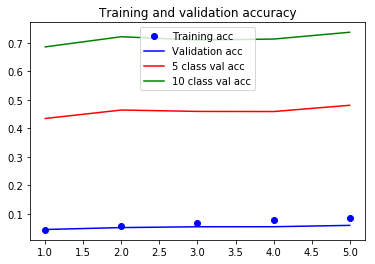

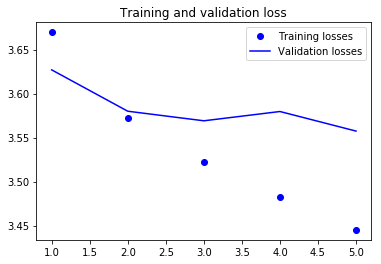

In [8]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
val_5_acc = history.history['val_five_claas_diff']
val_10_acc = history.history['val_ten_claas_diff']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_5_acc, 'r', label='5 class val acc')
plt.plot(epochs, val_10_acc, 'g', label='10 class val acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tuning

In [9]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy, five_claas_diff, ten_claas_diff]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=4540, 
                              epochs=30, 
                              validation_data=test_generator, 
                              callbacks=[
                                  keras.callbacks.ModelCheckpoint('model_cropped_data.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
                                  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
                              ],
                              validation_steps=500)

Epoch 1/30
4540/4540 [==============================] - 445s 98ms/step - loss: 3.5161 - categorical_accuracy: 0.0513 - five_claas_diff: 0.4931 - ten_claas_diff: 0.7579 - val_loss: 3.5551 - val_categorical_accuracy: 0.0531 - val_five_claas_diff: 0.4854 - val_ten_claas_diff: 0.7329
Epoch 2/30
4540/4540 [==============================] - 445s 98ms/step - loss: 3.3912 - categorical_accuracy: 0.0616 - five_claas_diff: 0.5614 - ten_claas_diff: 0.8206 - val_loss: 3.4346 - val_categorical_accuracy: 0.0592 - val_five_claas_diff: 0.5572 - val_ten_claas_diff: 0.8177
Epoch 3/30
4540/4540 [==============================] - 445s 98ms/step - loss: 3.3074 - categorical_accuracy: 0.0703 - five_claas_diff: 0.6041 - ten_claas_diff: 0.8516 - val_loss: 3.3985 - val_categorical_accuracy: 0.0650 - val_five_claas_diff: 0.5686 - val_ten_claas_diff: 0.8238
Epoch 4/30
4540/4540 [==============================] - 440s 97ms/step - loss: 3.2301 - categorical_accuracy: 0.0798 - five_claas_diff: 0.6406 - ten_claas_di

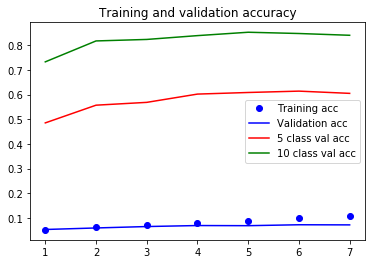

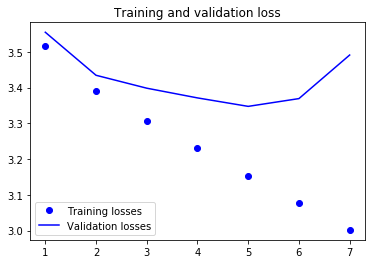

In [10]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
val_5_acc = history.history['val_five_claas_diff']
val_10_acc = history.history['val_ten_claas_diff']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_5_acc, 'r', label='5 class val acc')
plt.plot(epochs, val_10_acc, 'g', label='10 class val acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()